## German wings review challenge

The goal of this notebook is to show based on the customer review data how to predict the target variable 'Recommended'.
The data is found in a text file holding a set of reviews about the German wings airline (airline code ‘4U’).


In [385]:
import collections
from collections import Counter

import sys, os, re, csv, codecs, math

from datetime import datetime

import statsmodels.formula.api as smf

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import numpy as np
from numpy import inf

from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy import interp

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.fixes import signature

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import lightgbm as lgb

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence, text
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')

#stop_words = nltk.download('stopwords')
stop_words = stopwords.words('english')

np.random.seed(42)

[nltk_data] Downloading package punkt to /Users/kai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Load Data

In [386]:
def get_df_review(filename='4U_Reviews.txt', encoding = "ISO-8859-1"):
    """
    convert text data in the txt file into a pandas dataframe
    """
    #map the content to dictionary
    dict_review = {'Title':[], 
                   'User Name':[], 
                   'Country':[], 
                   'Date':[],
                   'Rating':[], 
                   'Review':[], 
                   'Type Of Traveller':[], 
                   'Cabin Flown':[], 
                   'Route':[], 
                   'Date Flown':[], 
                   'Seat Comfort':[], 
                   'Cabin Staff Service':[], 
                   'Ground Service':[], 
                   'Value For Money':[], 
                   'Recommended':[]
                  }

    other_info_names = ['Type Of Traveller', 
                        'Cabin Flown', 
                        'Route', 
                        'Date Flown', 
                        'Seat Comfort', 
                        'Cabin Staff Service', 
                        'Ground Service', 
                        'Value For Money', 
                        'Recommended'
                       ]
    
    f = open(filename, "r", encoding = encoding)
    
    review_info_list = [] 
    
    for line in f:
        if line == '\n':
            #print("-----")
            #print(review_info_list)

            # get Title, User Name, Country, Date, Rating, Review
            for i, line in enumerate(review_info_list):
                # get title
                if i == 0:
                    #print('title: {}'.format(line))
                    dict_review['Title'].append(line)
                # get user name, country, date
                elif i == 1:
                    user_name = ''
                    country_name = ''
                    date_str = ''
                    
                    pos_start = line.find('(')
                    pos_end = line.find(')')
                    if pos_start != -1:
                        user_name = line[0:pos_start].strip()
                        country_name = line[pos_start+1:pos_end].strip()
                        date_str = line[pos_end+1:].strip()
                    else:
                        str_list = line.split()
                        if len(str_list) == 5:
                            user_name = str_list[0] + ' ' + str_list[1]
                            country_name = ''
                            date_str = str_list[-3].strip() + ' ' + str_list[-2].strip() + ' ' + str_list[-1].strip()
                        
                    #print('user name: {}'.format(user_name))
                    #print('country name: {}'.format(country_name))
                    #print('date: {}'.format(date_str))
                    dict_review['User Name'].append(user_name)
                    dict_review['Country'].append(country_name)
                    dict_review['Date'].append(date_str)
                # get rating
                elif i == 2:
                    if line.strip() == 'na':
                        rating = np.nan
                    else:
                        rating = int(line.strip())
                    #print('rating: {}'.format(rating))
                    dict_review['Rating'].append(rating)
                # get review
                elif i == 3:
                    #print('review')
                    #print(line.strip())
                    dict_review['Review'].append(line.strip())
            
            # get other information     
            for info_name in other_info_names:
                review_info = ''
                for i, line in enumerate(review_info_list):
                    pos = line.find(info_name)
                    if pos != -1:
                        review_info = line[len(info_name)+1:].strip()
                        break
                dict_review[info_name].append(review_info)

            review_info_list = [] 
        else:
            line = line.replace('\"', '')
            #print(line)
            review_info_list.append(line)

    df_review = pd.DataFrame(dict_review)
    
    # get route to and route from   
    def f_from(x):
        if x:
            return x.split()[0]
        return ''
    def f_to(x):
        if x:
            return x.split()[2]
        return ''
    df_review['Route From'] = df_review['Route'].apply(f_from)
    df_review['Route To'] = df_review['Route'].apply(f_to)
    
    return df_review    

In [387]:
df_review = get_df_review()

## 2. EDA

In [388]:
df_review.head()

,Cabin Flown,Cabin Staff Service,Country,Date,Date Flown,Ground Service,Rating,Recommended,Review,Route,Seat Comfort,Title,Type Of Traveller,User Name,Value For Money,Route From,Route To
0,Economy,12345,Canada,16th October 2015,September 2015,12345,2.0,no,We flew with Germanwings (or tried to) on Sept...,Stuttgart to Amsterdam,12345,they have been unresponsive\n,Couple Leisure,Brian McNamee,12345,Stuttgart,Amsterdam
1,Economy,12345,United Kingdom,4th October 2015,September 2015,12345,3.0,no,I am less than impressed with Germanwings serv...,Hamburg to London,12345,I was refused some water\n,Solo Leisure,L Mouratidou,12345,Hamburg,London
2,Economy,12345,Germany,21st September 2015,September 2015,12345,3.0,no,Flew from Palma de Mallorca to Cologne with Ge...,PMI to CGN,12345,the service crew were friendly but nothing more\n,Couple Leisure,H Mutschler,12345,PMI,CGN
3,,12345,Germany,20th September 2015,August 2015,12345,10.0,yes,Good flight from Berlin-Tegel to London Heathr...,Berlin-Tegel to London Heathrow,12345,"no problems or delays, very friendly staff\n",Business,Oliver Numrich,12345,Berlin-Tegel,London
4,Economy,12345,Germany,14th September 2015,September 2015,12345,4.0,no,I don't get why Germanwings is always late and...,CGN to LHR,12345,I don't get why Germanwings is always late\n,Business,Andreas Huettenhoelscher,12345,CGN,LHR


In [389]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 17 columns):
Cabin Flown            127 non-null object
Cabin Staff Service    127 non-null object
Country                127 non-null object
Date                   127 non-null object
Date Flown             127 non-null object
Ground Service         127 non-null object
Rating                 114 non-null float64
Recommended            127 non-null object
Review                 127 non-null object
Route                  127 non-null object
Seat Comfort           127 non-null object
Title                  127 non-null object
Type Of Traveller      127 non-null object
User Name              127 non-null object
Value For Money        127 non-null object
Route From             127 non-null object
Route To               127 non-null object
dtypes: float64(1), object(16)
memory usage: 16.9+ KB


In [390]:
df_review.shape

(127, 17)

### 2.1 Analyse target 'Recommended' 

In [391]:
df_review['Recommended'].describe()

count     127
unique      2
top        no
freq       65
Name: Recommended, dtype: object

In [392]:
df_review['Recommended'].unique()

array(['no', 'yes'], dtype=object)

In [393]:
df_review['Recommended'].isnull().sum()

0

In [394]:
# Transfer string into integer
lbl_enc = preprocessing.LabelEncoder()
df_review['Recommended Label'] = lbl_enc.fit_transform(df_review['Recommended'].values)

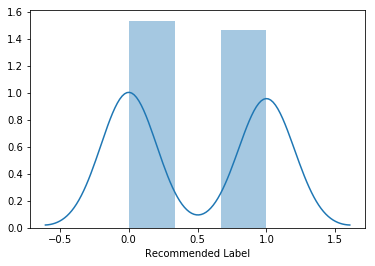

In [395]:
sns.distplot(df_review['Recommended Label'])

In [396]:
df_review[df_review['Recommended Label'] == 1].shape

(62, 18)

In [397]:
df_review[df_review['Recommended Label'] == 0].shape

(65, 18)

It shows the data of two classes is balanced.

### 2.2 Analyse target 'Rating' 

In [398]:
df_review['Rating'].describe()

count    114.000000
mean       5.587719
std        2.874395
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       10.000000
Name: Rating, dtype: float64

In [399]:
df_review['Rating'].isnull().sum()

13

In [400]:
df_review[df_review['Rating'].notnull()].shape

(114, 18)

In [401]:
df_review.shape

(127, 18)

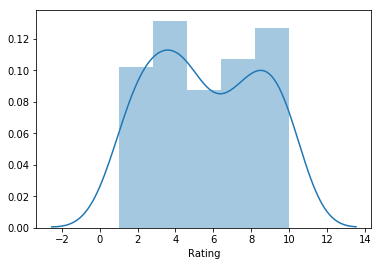

In [402]:
sns.distplot(df_review[df_review['Rating'].notnull()]['Rating'])

### 2.3 Analyse Missing Numerical Data

In [403]:
total = df_review.isnull().sum().sort_values(ascending=False)
percent = (df_review.isnull().sum()/df_review.count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(20)
missing_data

,Total,Percent
Rating,13,0.114035
Recommended Label,0,0.000000
Route To,0,0.000000
Cabin Staff Service,0,0.000000
Country,0,0.000000
Date,0,0.000000
Date Flown,0,0.000000
Ground Service,0,0.000000
Recommended,0,0.000000
Review,0,0.000000


It shows that 10% of the customer does not rate the flights.

### 2.4 Show relationship between 'Recommended' and other variables

- Relationship with numerical variables

In [404]:
def show_relation_numerical(df, var, target):
    data = pd.concat([df[target], df[var]], axis=1)
    data.plot.scatter(x=var, y=target)

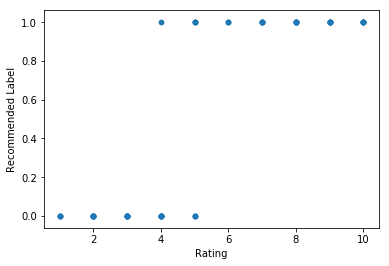

In [405]:
num_vars = ['Rating']

for num_var in num_vars:
    show_relation_numerical(df_review, num_var, 'Recommended Label')

It shows that 'Rating' is an important feature to distinguish the target variable 'Recommended'.

- Relationship with categorical features

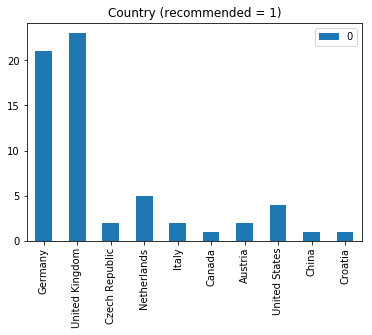

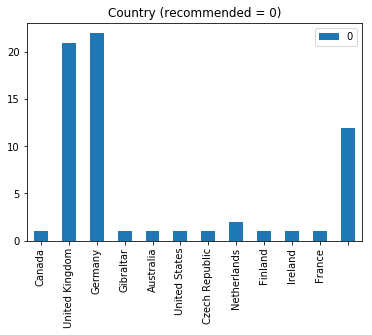

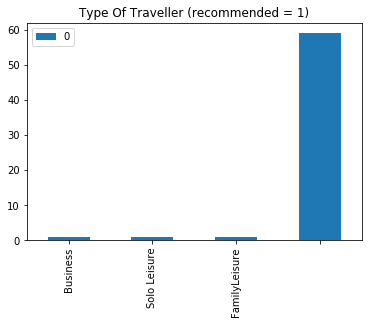

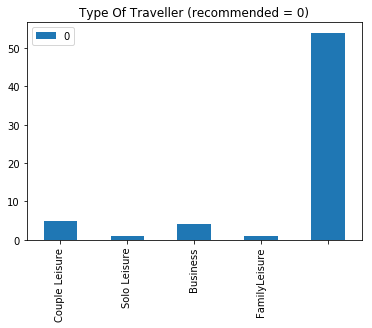

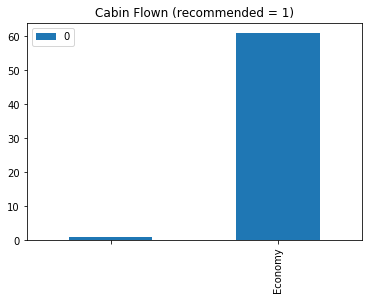

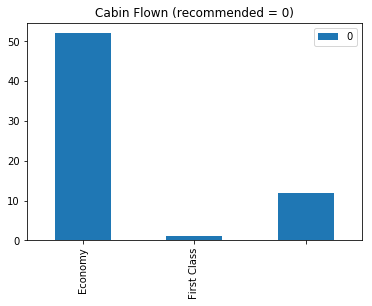

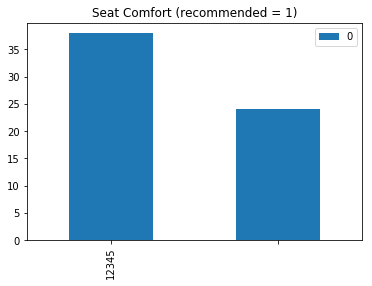

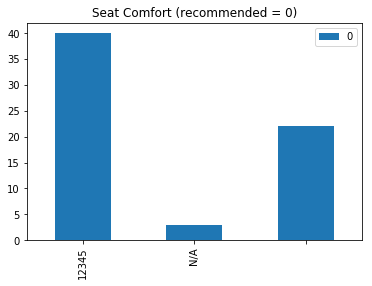

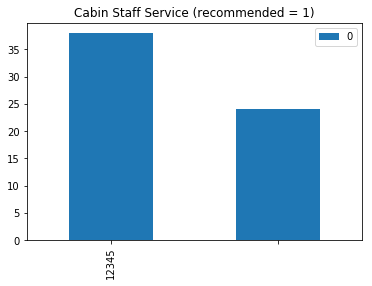

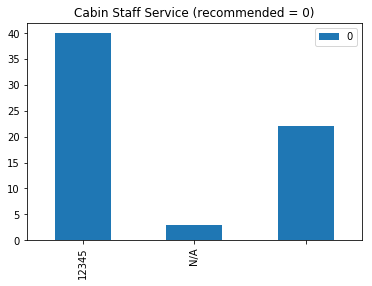

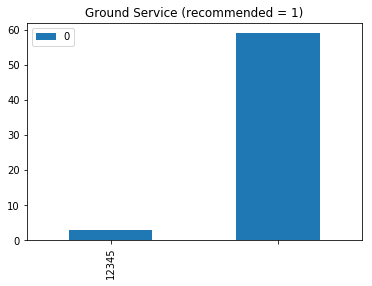

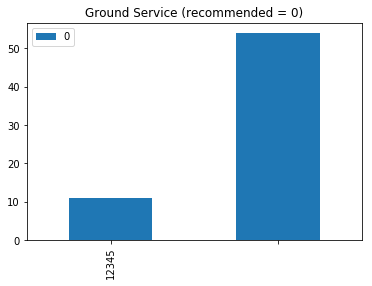

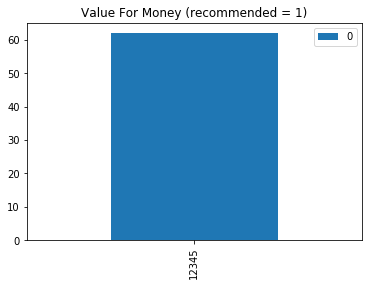

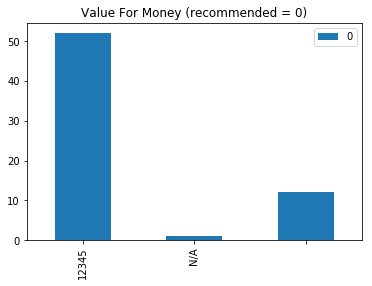

In [406]:
cat_vars = ['Country', 'Type Of Traveller', 'Cabin Flown', 'Seat Comfort', 'Cabin Staff Service', 'Ground Service', 'Value For Money']
                  
# https://stackoverflow.com/questions/28418988/how-to-make-a-histogram-from-a-list-of-strings-in-python
def plot_strings(a, title=''):
    letter_counts = Counter(a)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    df.plot(kind='bar', title=title)

    
for cat_var in cat_vars:
    df = df_review[df_review['Recommended Label'] == 1][[cat_var]]
    plot_strings(df[cat_var].tolist(), title=cat_var+' (recommended = 1)')
    
    df = df_review[df_review['Recommended Label'] == 0][[cat_var]]
    plot_strings(df[cat_var].tolist(), title=cat_var+' (recommended = 0)')
    

It shows that there is a lot of missing data in the categorical features. The categorical features are not usefull to predict target variable 'Recommended'.

### 2.5 Text analysis

Reference:
https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

- Title

In [407]:
df_review['Title'].unique()

array(['they have been unresponsive\n', 'I was refused some water\n',
       'the service crew were friendly but nothing more\n',
       'no problems or delays, very friendly staff\n',
       "I don't get why Germanwings is always late\n",
       'vowing never to book Germanwings again\n',
       'staff friendly - food terrible\n',
       'no explanations, no offers of help\n',
       'delay in Heathrow about 1:30 minutes\n',
       'Germanwings customer review\n'], dtype=object)

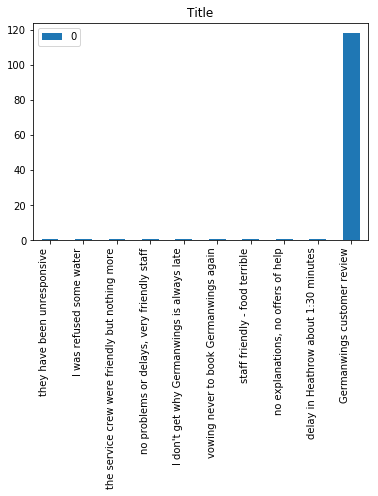

In [408]:
plot_strings(df_review['Title'], title='Title')

It shows that most of the reviews have the title 'Germanwings customer review'. Therefore, I will not use 'Title' as a feature to predict 'Recommended'

- TODO: Review

In [409]:
df_review["Review"] = df_review["Review"].fillna("_na_").values

## 3. Modelling

The recommendation problem is formulated into a binary classification problem, i.e., classify the text data (review) into recommended and non-recommended.

- Define evaluation metric
Kaggle has specified multi-class log-loss as evaluation metric. 
This is implemented in the follow way 
taken from: 
https://github.com/dnouri/nolearn/blob/master/nolearn/lasagne/util.py)
https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

In [410]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

- Plot precision recall curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

In [411]:
def plot_pr_curve(y_test, y_score, model_name, features):
    average_precision = average_precision_score(y_test, y_score)
    
    #print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    precision, recall, _ = precision_recall_curve(y_test, y_score)
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}, model={1}, features={2}'.format(average_precision, 
                                                                                           model_name,
                                                                                           features
                                                                                          ))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

- Plot AUC curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://qiita.com/bmj0114/items/460424c110a8ce22d945

In [412]:
def plot_auc_curve(y_test, y_score, model_name, features):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    score = roc_auc_score(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: ROC_AUC_Score={0:0.2f}, model={1}, features={2}'.format(score, 
                                                                                                          model_name,
                                                                                                          features
                                                                                                         ))
    plt.legend(loc="lower right")
    plt.show()

- Prepare data sets

In [413]:
y = df_review['Recommended Label']

In [414]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df_review['Review'].values, 
                                                  y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.2, 
                                                  shuffle=True)

In [415]:
print (xtrain.shape)
print (xvalid.shape)

(101,)
(26,)


- #### TF-IDF
The first model is a TF-IDF (Term Frequency - Inverse Document Frequency) followed by a simple Logistic Regression.

In [416]:
tfv = TfidfVectorizer(min_df=3,  
                      max_features=None, 
                      strip_accents='unicode', 
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english',
                     )

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [417]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
ypred = clf.predict(xvalid_tfv)

- #### Logloss

For a binary classification like our example, the typical loss function is the binary cross-entropy / log loss.

$$H_p(q) = - \frac{1}{N} \sum_{i=1}^{N} y_i \times log(p(y_i)) + (1-y_i) \times log(1-p(y_i))$$

Neural networks are trained using stochastic gradient descent and require that you choose a loss function when designing and configuring your model.

Given input, the model is trying to make predictions that match the data distribution of the target variable. Under maximum likelihood, a loss function estimates how closely the distribution of predictions made by a model matches the distribution of target variables in the training data.

**Cross-Entropy Loss** (or Log Loss)

Cross-entropy loss is often simply referred to as “cross-entropy,” “logarithmic loss,” “logistic loss,” or “log loss” for short.

Each predicted probability is compared to the actual class output value (0 or 1) and a score is calculated that penalizes the probability based on the distance from the expected value. The penalty is logarithmic, offering a small score for small differences (0.1 or 0.2) and enormous score for a large difference (0.9 or 1.0).

Cross-entropy loss is minimized, where smaller values represent a better model than larger values. A model that predicts perfect probabilities has a cross entropy or log loss of 0.0.

Cross-entropy for a binary or two class prediction problem is actually calculated as the average cross entropy across all examples.

Given a framework of maximum likelihood, we know that we want to use a cross-entropy or mean squared error loss function under stochastic gradient descent.

Nevertheless, we may or may not want to report the performance of the model using the loss function.

For example, logarithmic loss is challenging to interpret, especially for non-machine learning practitioner stakeholders. The same can be said for the mean squared error. Instead, it may be more important to report the accuracy and root mean squared error for models used for classification and regression respectively.

It may also be desirable to choose models based on these metrics instead of loss. This is an important consideration, as the model with the minimum loss may not be the model with best metric that is important to project stakeholders.

A good division to consider is to use the loss to evaluate and diagnose how well the model is learning. This includes all of the considerations of the optimization process, such as overfitting, underfitting, and convergence. An alternate metric can then be chosen that has meaning to the project stakeholders to both evaluate model performance and perform model selection.

The same metric can be used for both concerns but it is more likely that the concerns of the optimization process will differ from the goals of the project and different scores will be required. Nevertheless, it is often the case that improving the loss improves or, at worst, has no effect on the metric of interest.


**Reference**

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

https://medium.com/30-days-of-machine-learning/day-5-entropy-relative-entropy-and-cross-entropy-8369d67cc180

https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/

In [418]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.611 


- #### Precision Recall curve

    - Precision-Recall curves summarize the trade-off between the **true positive rate** and the **positive predictive value** for a predictive model using different probability thresholds.
    - Precision-Recall curves are appropriate for imbalanced datasets, whereas ROC curves are appropriate when the observations are balanced between each class.

**Precision** is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.

$${Precision} = \frac{True Positives} {(True Positives + False Positives)}$$

**Recall** is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

$${Recall} = \frac{True Positives} {(True Positives + False Negatives)}$$

Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1).

The reason for this is that typically the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives.

There are also composite scores that attempt to summarize the precision and recall; three examples include:

- **F score** or **F1 score**: that calculates the harmonic mean of the precision and recall (harmonic mean because the precision and recall are ratios).

- **Average precision**: that summarizes the weighted increase in precision with each change in recall for the thresholds in the precision-recall curve.

- **Area Under Curve**: like the AUC, summarizes the integral or an approximation of the area under the precision-recall curve.

In terms of model selection, F1 summarizes model skill for a specific probability threshold, whereas average precision and area under curve summarize the skill of a model across thresholds, like ROC AUC.

This makes precision-recall and a plot of precision vs. recall and summary measures useful tools for binary classification problems that have an imbalance in the observations for each class.

The above explaination of Precision and Recall is taken from

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/



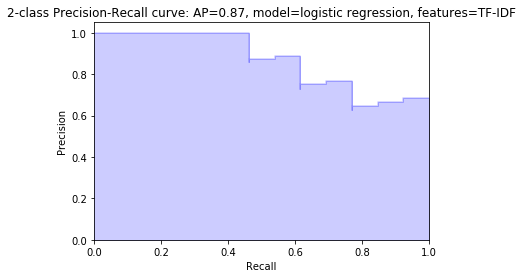

In [419]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='logistic regression', features='TF-IDF')

In [420]:
print(classification_report(yvalid.values, ypred))

             precision    recall  f1-score   support

          0       0.75      0.69      0.72        13
          1       0.71      0.77      0.74        13

avg / total       0.73      0.73      0.73        26



- #### ROC curve

    - ROC Curves summarize the trade-off between the **true positive rate** and **false positive rate** for a predictive model using different probability thresholds.
    
    - ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.
    
$${True Positive Rate} = \frac{True Positives} {(True Positives + False Negatives)}$$
The true positive rate is also referred to as sensitivity.

$${False Positive Rate} = \frac{False Positives} {(False Positives + True Negatives)}$$

The false positive rate is also referred to as the inverted specificity where specificity is the total number of true negatives divided by the sum of the number of true negatives and false positives.

$${Specificity} = \frac{True Negatives} {(True Negatives + False Positives)}$$

$${False Positive Rate} = 1 - {Specificity}$$

The ROC curve is a useful tool for a few reasons:

- The curves of different models can be compared directly in general or for different thresholds.
- The area under the curve (AUC) can be used as a summary of the model skill.


https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

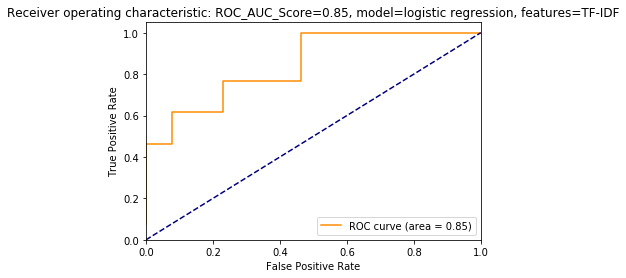

In [421]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='logistic regression',  features='TF-IDF')

In [422]:
roc_auc_score(yvalid, predictions[:, 1])

0.8461538461538461

- Error analysis

In [423]:
def get_error_pred(yvalid, ypred):
    """
    Generate a dataframe contains the missclassified data
    """
    index_error = yvalid != ypred
    x_error = xvalid[index_error]
    ytrue_error = yvalid[index_error].values
    ypred_error = ypred[index_error]
    
    df_error = pd.DataFrame({'x':x_error, 'y_true':ytrue_error, 'y_pred':ypred_error})
    
    return df_error

In [424]:
df_error = get_error_pred(yvalid, ypred)

In [425]:
for index, row in df_error.iterrows():
    print('index: {}'.format(index))
    print(row['x'])
    print('true label: {}'.format(row['y_true']))
    print('\n')

index: 0
Booked Lufthansa flight Cologne-Berlin on 28 Jan. On 2 Jan I got the information that the flight was operated by Germanwings a German low-cost carrier. So was the flight. Low cost: 1 hrs delayed for my beer I had to pay in Euros - cash. Lounge use was denied as the flight was operated under 4U code. No service for a high Lufthansa price. Not recommended very disappointed.
true label: 0


index: 1
First time I have used Germanwings for connecting flights (via Hamburg). The APP does not work properly. They are unable to issue both boarding cards on check in causing unnecessary inconvenience. Their Live Twitter response averages 24 hours to reply. Cabin crew spend most time behind front galley curtains. Also fail to do proper cabin secure checks prior to landing. Seats new ultra thin models OK for short flights. Seat pitch OK on the extra space seats. Smart fare snack boring and repetitive. They have taken over a lot of Lufthansa routes and to be honest they are not really geared

Review 2 is not clear for me it was positive or negative.

Reviews 4, 5 has some pros and cons.

Reviews 3, 6 could be neutral.

- #### Count Features

Instead of using TF-IDF, we can also use word counts as features. This can be done easily using CountVectorizer from scikit-learn.

In [426]:
ctv = CountVectorizer(analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      stop_words = 'english'
                     )

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))

xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [427]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression()
clf.fit(xtrain_ctv, ytrain)

predictions = clf.predict_proba(xvalid_ctv)
ypred = clf.predict(xvalid_ctv)

In [428]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.553 


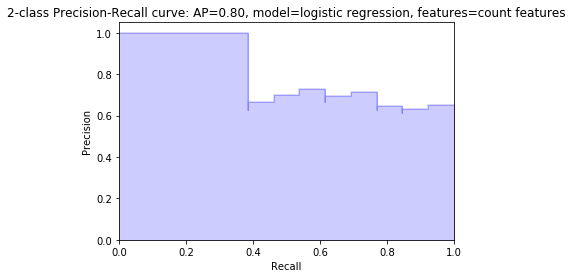

In [429]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='logistic regression', features='count features')

In [430]:
print(classification_report(yvalid.values, ypred))

             precision    recall  f1-score   support

          0       0.70      0.54      0.61        13
          1       0.62      0.77      0.69        13

avg / total       0.66      0.65      0.65        26



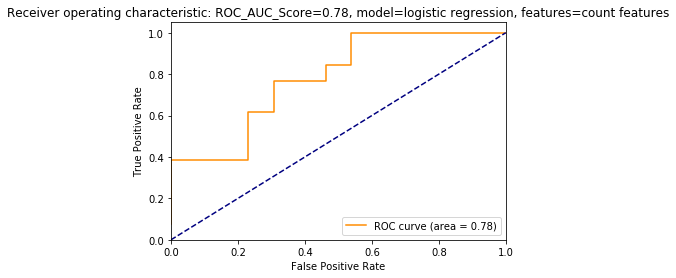

In [431]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='logistic regression',  features='count features')

In [432]:
roc_auc_score(yvalid, predictions[:, 1])

0.7810650887573964

In [433]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
ypred = clf.predict(xvalid_tfv)

In [434]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.556 


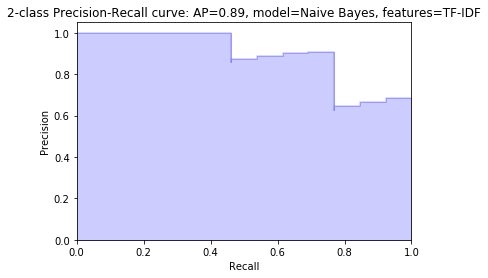

In [435]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='Naive Bayes', features='TF-IDF')

In [436]:
print(classification_report(yvalid.values, ypred))

             precision    recall  f1-score   support

          0       0.73      0.62      0.67        13
          1       0.67      0.77      0.71        13

avg / total       0.70      0.69      0.69        26



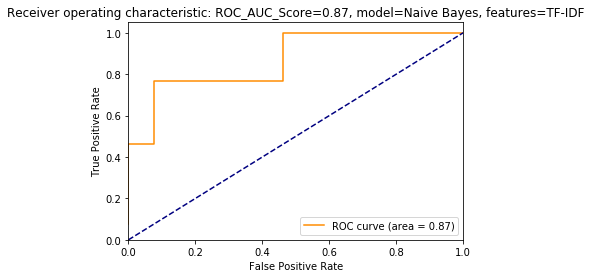

In [437]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='Naive Bayes',  features='TF-IDF')

In [438]:
roc_auc_score(yvalid, predictions[:, 1])

0.8698224852071006

It shows that Navis bayes classifier with count features achieves better ROC AUC score (0.87) compare to other settings.

In [439]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)

predictions = clf.predict_proba(xvalid_ctv)
ypred = clf.predict(xvalid_ctv)

In [440]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 3.732 


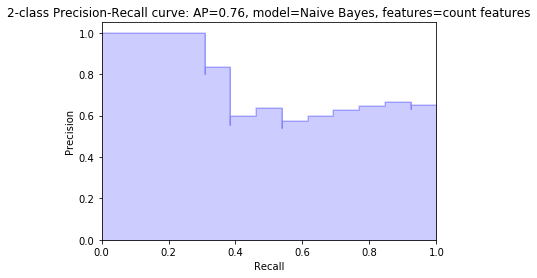

In [441]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='Naive Bayes', features='count features')

In [442]:
print(classification_report(yvalid.values, ypred))

             precision    recall  f1-score   support

          0       1.00      0.31      0.47        13
          1       0.59      1.00      0.74        13

avg / total       0.80      0.65      0.61        26



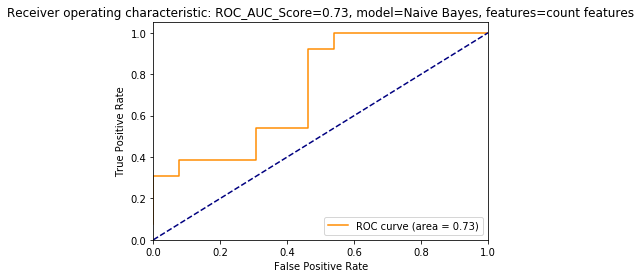

In [443]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='Naive Bayes',  features='count features')

In [444]:
roc_auc_score(yvalid, predictions[:, 1])

0.7278106508875739

- ### XGBoost

In [445]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())
ypred = clf.predict(xvalid_tfv.tocsc())


In [446]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.546 


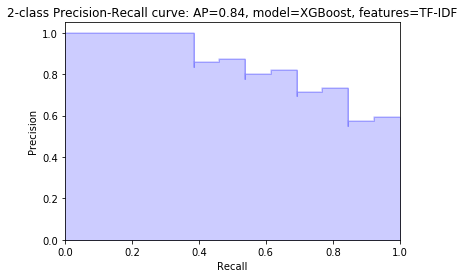

In [447]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='XGBoost', features='TF-IDF')

In [448]:
print(classification_report(yvalid.values, ypred))

             precision    recall  f1-score   support

          0       0.71      0.77      0.74        13
          1       0.75      0.69      0.72        13

avg / total       0.73      0.73      0.73        26



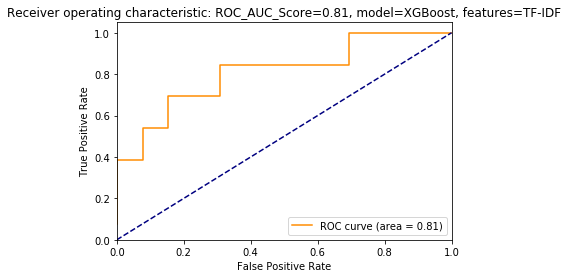

In [449]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='XGBoost',  features='TF-IDF')

In [450]:
roc_auc_score(yvalid, predictions[:, 1])

0.8106508875739644

In [451]:
# Fitting a simple xgboost on count features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

clf.fit(xtrain_ctv, ytrain)

predictions = clf.predict_proba(xvalid_ctv)
ypred = clf.predict(xvalid_ctv)

In [452]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.638 


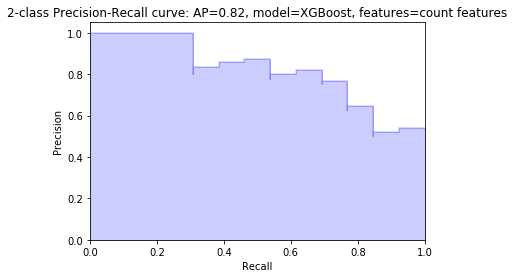

In [453]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='XGBoost', features='count features')

In [454]:
print(classification_report(yvalid.values, ypred))

             precision    recall  f1-score   support

          0       0.77      0.77      0.77        13
          1       0.77      0.77      0.77        13

avg / total       0.77      0.77      0.77        26



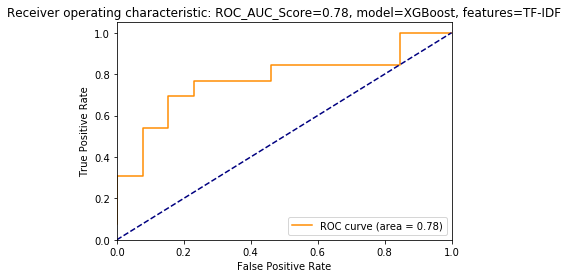

In [455]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='XGBoost',  features='TF-IDF')

In [456]:
roc_auc_score(yvalid, predictions[:, 1])

0.7751479289940828

It shows that with xgboost on the tfidf, we achieve better roc-auc score compared to count features.

- #### Hyperparameter tuning


In [457]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

In [458]:
regr_xgb = xgb.XGBClassifier()

param_dist = {'learning_rate': [0.01, 0.05, 0.07], 
              'max_depth': [4, 6],
              'n_estimators': [100, 200, 500],
              #'min_child_weight': [2, 4],
              #'silent': [1],
              #'subsample': [0.7],
              #'colsample_bytree': [0.7],
              #'nthread':[4], #when use hyperthread, xgboost may become slower
             }

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
random_search = RandomizedSearchCV(estimator = regr_xgb, 
                                   param_distributions = param_dist, 
                                   n_jobs = 4,
                                   n_iter = 2,
                                   cv = 3,
                                   verbose=2,
                                   scoring=mll_scorer,
                                  )

random_search.fit(xtrain_tfv.tocsc(), ytrain)

print('xgboost (hyperparameter tuning with random search)')
print(random_search.best_score_)
print(random_search.best_params_)

predictions = random_search.predict_proba(xvalid_tfv.tocsc())
ypred = random_search.predict(xvalid_tfv.tocsc())


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=100, max_depth=4, learning_rate=0.01 ...............
[CV] n_estimators=100, max_depth=4, learning_rate=0.01 ...............
[CV] n_estimators=100, max_depth=4, learning_rate=0.01 ...............
[CV] n_estimators=500, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=100, max_depth=4, learning_rate=0.01, total=   0.1s
[CV] n_estimators=500, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=100, max_depth=4, learning_rate=0.01, total=   0.1s
[CV]  n_estimators=100, max_depth=4, learning_rate=0.01, total=   0.1s
[CV] n_estimators=500, max_depth=6, learning_rate=0.01 ...............


[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:    0.1s remaining:    0.1s


[CV]  n_estimators=500, max_depth=6, learning_rate=0.01, total=   0.5s
[CV]  n_estimators=500, max_depth=6, learning_rate=0.01, total=   0.5s
[CV]  n_estimators=500, max_depth=6, learning_rate=0.01, total=   0.5s


[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:    0.6s finished


xgboost (hyperparameter tuning with random search)
-0.5967701518594628
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01}


In [459]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.533 


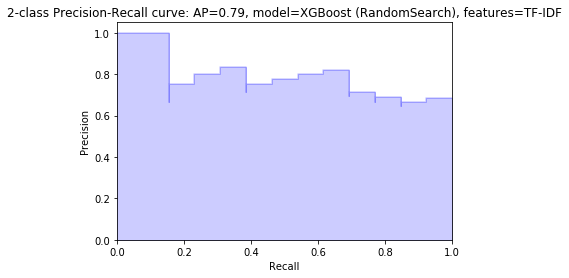

In [460]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='XGBoost (RandomSearch)', features='TF-IDF')

In [461]:
print(classification_report(yvalid.values, ypred))

             precision    recall  f1-score   support

          0       0.75      0.69      0.72        13
          1       0.71      0.77      0.74        13

avg / total       0.73      0.73      0.73        26



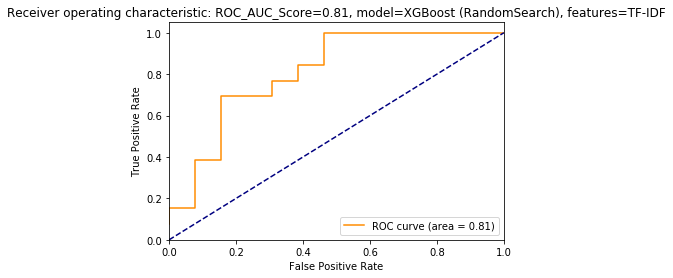

In [462]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='XGBoost (RandomSearch)',  features='TF-IDF')

In [463]:
roc_auc_score(yvalid, predictions[:, 1])

0.8106508875739644

It shows that random search hyperparameter tuning does not improve the performance.

- #### Word Embeddings 

Download the GloVe vectors from here 
http://www-nlp.stanford.edu/data/glove.840B.300d.zip


**Reference**

- Word embedding


https://machinelearningmastery.com/what-are-word-embeddings/


https://www.youtube.com/watch?v=5PL0TmQhItY



- Glove embedding

https://www.kaggle.com/stacykurnikova/using-glove-embedding

https://www.quora.com/How-is-GloVe-different-from-word2vec


- Fast word embedding

https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings

https://spenai.org/bravepineapple/faster_em/


- NLP

https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-069

https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout

In [464]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:06, 57534.66it/s]

Found 400000 word vectors.


In [465]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    #stop_words = nltk.download('stopwords')
    #words = str(s).lower().decode('utf-8')
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [466]:
# create sentence vectors using the above function for training and validation set

xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 26/26 [00:00<00:00, 735.77it/s]


In [467]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [468]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

clf.fit(xtrain_glove, ytrain)

predictions = clf.predict_proba(xvalid_glove)
ypred = clf.predict(xvalid_glove)

In [469]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.918 


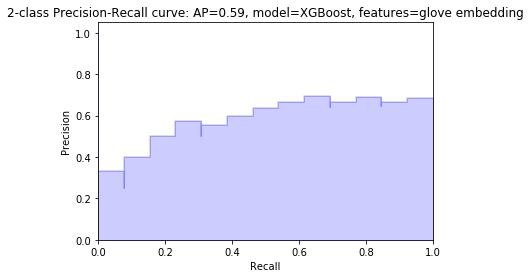

In [470]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='XGBoost', features='glove embedding')

In [471]:
print(classification_report(yvalid.values, ypred))

             precision    recall  f1-score   support

          0       0.64      0.69      0.67        13
          1       0.67      0.62      0.64        13

avg / total       0.65      0.65      0.65        26



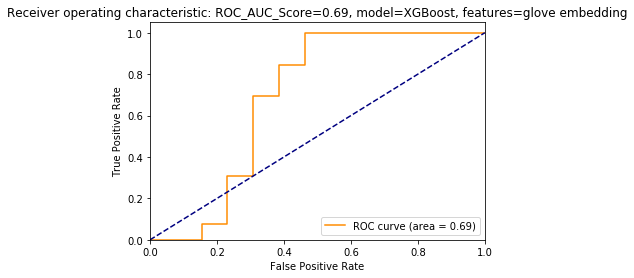

In [472]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='XGBoost',  features='glove embedding')

In [473]:
roc_auc_score(yvalid, predictions[:, 1])

0.6863905325443787

It shows that using xgboost with glove embedding features does not improve the performance.

- ### Deep Learning

In [474]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [475]:
xtrain_glove.shape

(101, 50)

In [476]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [477]:
ytrain_enc.shape

(101, 2)

In [478]:
yvalid_enc.shape

(26, 2)

In [479]:
xtrain_glove.shape[1]

50

In [480]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=xtrain_glove.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [481]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=10, verbose=1, 
          #validation_data=(xvalid_glove_scl, yvalid_enc)
         )

Epoch 1/10
101/101 [==============================] - 2s 19ms/step - loss: 0.8432
Epoch 2/10
101/101 [==============================] - 0s 147us/step - loss: 0.6149
Epoch 3/10
101/101 [==============================] - 0s 115us/step - loss: 0.4212
Epoch 4/10
101/101 [==============================] - 0s 158us/step - loss: 0.3444
Epoch 5/10
101/101 [==============================] - 0s 131us/step - loss: 0.2736
Epoch 6/10
101/101 [==============================] - 0s 146us/step - loss: 0.2347
Epoch 7/10
101/101 [==============================] - 0s 135us/step - loss: 0.2400
Epoch 8/10
101/101 [==============================] - 0s 118us/step - loss: 0.1879
Epoch 9/10
101/101 [==============================] - 0s 125us/step - loss: 0.1477
Epoch 10/10
101/101 [==============================] - 0s 108us/step - loss: 0.0972


In [482]:
predictions = model.predict(xvalid_glove_scl)

In [483]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 1.024 


In [484]:
ypred = predictions.argmax(axis=-1)

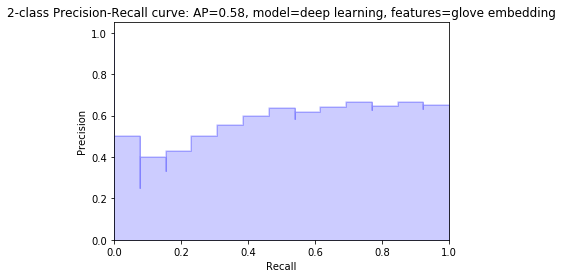

In [485]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='deep learning', features='glove embedding')

In [486]:
print(classification_report(yvalid.values, ypred))

             precision    recall  f1-score   support

          0       0.60      0.69      0.64        13
          1       0.64      0.54      0.58        13

avg / total       0.62      0.62      0.61        26



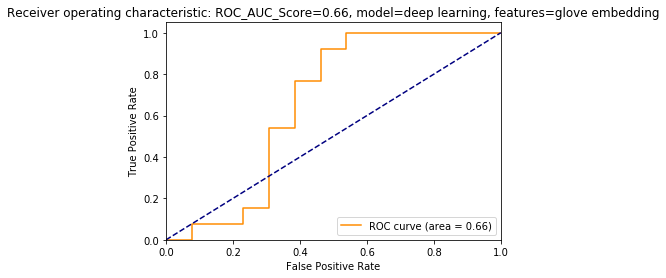

In [487]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='deep learning',  features='glove embedding')

In [488]:
roc_auc_score(yvalid, predictions[:, 1])

0.6568047337278107

- #### LSTM

In [489]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [490]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, xtrain_glove.shape[1]))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 2152/2152 [00:00<00:00, 401572.37it/s]


In [491]:
embedding_matrix.shape

(2153, 50)

In [492]:
len(word_index) + 1

2153

In [508]:
# LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(5, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [526]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=1024, epochs=200, verbose=0, 
          #validation_data=(xvalid_pad, yvalid_enc)
         )

In [527]:
predictions = model.predict(xvalid_pad)

In [528]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.843 


In [529]:
ypred = predictions.argmax(axis=-1)

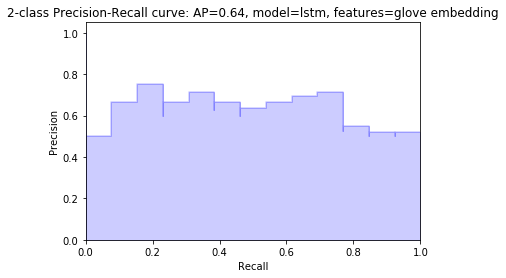

In [530]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='lstm', features='glove embedding')

In [531]:
print(classification_report(yvalid.values, ypred))

             precision    recall  f1-score   support

          0       0.56      0.69      0.62        13
          1       0.60      0.46      0.52        13

avg / total       0.58      0.58      0.57        26



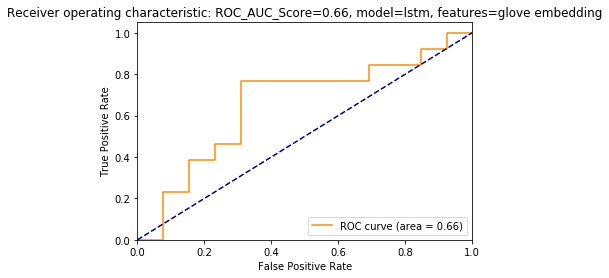

In [532]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='lstm',  features='glove embedding')

In [533]:
roc_auc_score(yvalid, predictions[:, 1])

0.6568047337278107

In [534]:
# LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(10, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [535]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), 
          callbacks=[earlystop]
         )

Train on 101 samples, validate on 26 samples
Epoch 1/100
101/101 [==============================] - 4s 36ms/step - loss: 0.6907 - val_loss: 0.6857
Epoch 2/100
101/101 [==============================] - 0s 882us/step - loss: 0.6839 - val_loss: 0.6845
Epoch 3/100
101/101 [==============================] - 0s 804us/step - loss: 0.7050 - val_loss: 0.6833
Epoch 4/100
101/101 [==============================] - 0s 915us/step - loss: 0.6975 - val_loss: 0.6817
Epoch 5/100
101/101 [==============================] - 0s 1ms/step - loss: 0.6939 - val_loss: 0.6805
Epoch 6/100
101/101 [==============================] - 0s 845us/step - loss: 0.6962 - val_loss: 0.6793
Epoch 7/100
101/101 [==============================] - 0s 795us/step - loss: 0.7049 - val_loss: 0.6782
Epoch 8/100
101/101 [==============================] - 0s 756us/step - loss: 0.6975 - val_loss: 0.6770
Epoch 9/100
101/101 [==============================] - 0s 725us/step - loss: 0.7052 - val_loss: 0.6757
Epoch 10/100
101/101 [=========

In [536]:
predictions = model.predict(xvalid_pad)

In [537]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.620 


In [538]:
ypred = predictions.argmax(axis=-1)

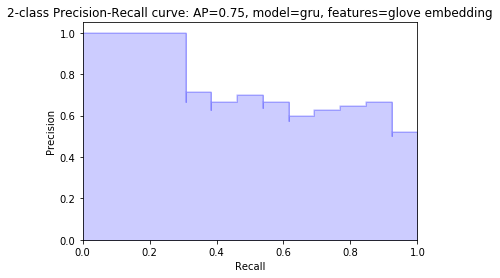

In [541]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='gru', features='glove embedding')

In [542]:
print(classification_report(yvalid.values, ypred))

             precision    recall  f1-score   support

          0       0.58      0.54      0.56        13
          1       0.57      0.62      0.59        13

avg / total       0.58      0.58      0.58        26



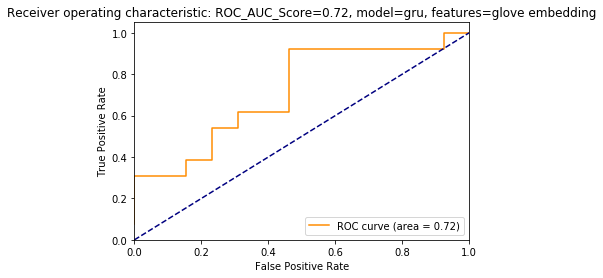

In [543]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='gru',  features='glove embedding')

- ### Reference

**EDA**

**Evaluation**

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

https://medium.com/30-days-of-machine-learning/day-5-entropy-relative-entropy-and-cross-entropy-8369d67cc180

https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/


**NLP**

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/kernels

https://www.kaggle.com/c/spooky-author-identification/kernels

https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing

https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline



https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams


**General Data Science**

https://www.kaggle.com/kernels?sortBy=voteCount&group=everyone&pageSize=20